### File Explanation

**trainRNN_HBTRC_ANM_StaticModel.ipynb:**
<br> This notebook is to load AddNeuroMed examples from 'preprocessData.pickle', and HBTRC examples from 'preprocessData_HBTRC.pickle' and create a "Static Network". Train the network on HBTRC data set and test on AddNeuroMed data set

**Variables information**:
<br> 1) Variables in the format of xxx_A represents data from AddNeuroMed
<br> 2) Variables in the format of xxx_H represents data from HBTRC

**Processes are as follows:**
<br> 1) Load all variables from 'preprocessData.pickle' and 'preprocessData_HBTRC.pickle'
<br> 2) Parameter and hyperparameter assignments (location: **3rd cell**)
<br> 3) Create LSTM cells with Dropout Wrappers for gene A and gene B (function: **dropoutWrapper** in **trainRNN_network_utils.py**)
<br> 4) Using LSTM cells, create multi-layer static model (function: **LSTM_Model** in **trainRNN_network_utils.py**)
<br> 5) Create a single normalised output by using the last outputs of static models of gene A and gene B (function: **batch_normalised_sum** in **trainRNN_network_utils.py**)
<br> 6) Pass the output through a **dense** layer and make prediction with **softmax**
<br> 7) Before starting the training: concatenate rSnpG_tr_nXSN and rRnaG_nXS where G represents gene A and gene B (function: **input_reshape** in **trainRNN_utils.py**)
<br> 7) Train the network: every epoch (i.e., iteration) shuffle the data within each class (function: **shuffle_classes** in **trainRNN_utils.py**) and train in batches (function: **extract_batch_size** in **trainRNN_utils.py**)
<br> 8) Plot results with **plot_one_input** in **trainRNN_plot_utils.py**)
<br> 9) Save them in "resultsStatic_HBTRC_ANM.pickle" to be called when necessary

**Variables created:**
<br> 1) **trainLosses**: Train losses, dictionary, keys of (dropout)
<br> 2) **testLosses**: Test losses, dictionary, keys of (dropout)
<br> 3) **F1_scores**: F1_scores, dictionary, keys of (dropout)
<br> 4) **trainAccuracy**: Train accuracy, dictionary, keys of (dropout)

In [1]:
import tensorflow as tf
from IPython.core.debugger import set_trace #set_trace()
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

import os
os.environ[ "CUDA_VISIBLE_DEVICES" ] = "3"

%matplotlib inline

In [1]:
# LOAD AddNeuroMed DATA
# Load data form the pickle produced by "preprocessData_TT_v3.ipynb" in AddNeuroMed folder

# Save data into Python friendly file
import pickle
with open('../AddNeuroMed/preprocessData.pickle', 'rb') as f:
    rSnpA_nXSN_A = pickle.load( f )
    rSnpB_nXSN_A = pickle.load( f )
    rRnaA_nXS_A = pickle.load( f )
    rRnaB_nXS_A = pickle.load( f )
    rRelated_nXC_A = pickle.load( f )
    rSnpA_tr_nXSN_A = pickle.load( f )
    rSnpB_tr_nXSN_A = pickle.load( f )
    rRnaA_tr_nXS_A = pickle.load( f )
    rRnaB_tr_nXS_A = pickle.load( f )
    rRelated_tr_nXC_A = pickle.load( f )
    rSnpA_tst_nXSN_A = pickle.load( f )
    rSnpB_tst_nXSN_A = pickle.load( f )
    rRnaA_tst_nXS_A = pickle.load( f )
    rRnaB_tst_nXS_A = pickle.load( f )
    rRelated_tst_nXC_A = pickle.load( f )
    sGeneNames_nX2_A = pickle.load( f )
    nRs_A = pickle.load( f )
    nSs_A = pickle.load( f )
    print( 'AddNeuroMed data loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN_A.shape ) == 3 )
assert( len( rSnpB_nXSN_A.shape ) == 3 )
assert( len( rRnaA_nXS_A.shape ) == 2 )
assert( len( rRnaB_nXS_A.shape ) == 2)
assert( len( rRelated_nXC_A.shape ) == 2 )
assert( len( rSnpA_tr_nXSN_A.shape ) == 3 )
assert( len( rSnpB_tr_nXSN_A.shape ) == 3 )
assert( len( rRnaA_tr_nXS_A.shape ) == 2 )
assert( len( rRnaB_tr_nXS_A.shape ) == 2 )
assert( len( rRelated_tr_nXC_A.shape ) == 2 )
assert( len( rSnpA_tst_nXSN_A.shape ) == 3 )
assert( len( rSnpB_tst_nXSN_A.shape ) == 3 )
assert( len( rRnaA_tst_nXS_A.shape ) == 2 )
assert( len( rRnaB_tst_nXS_A.shape ) == 2 )
assert( len( rRelated_tst_nXC_A.shape ) == 2)
assert( rSnpA_nXSN_A.shape[ 0 ] == rRnaA_nXS_A.shape[0] )
assert( rSnpA_nXSN_A.shape[ 0 ] == rRnaB_nXS_A.shape[0] )
assert( rSnpB_nXSN_A.shape[ 0 ] == rRnaA_nXS_A.shape[0] )
assert( rSnpB_nXSN_A.shape[ 0 ] == rRnaB_nXS_A.shape[0] )
assert( rSnpA_nXSN_A.shape[ 0 ] == rRelated_nXC_A.shape[ 0 ] )
assert( rSnpA_nXSN_A.shape[ 1 ] == rRnaA_nXS_A.shape[ 1 ] )
assert( rSnpB_nXSN_A.shape[ 1 ] == rRnaB_nXS_A.shape[ 1 ] )
assert( rRelated_nXC_A.shape[ 1 ] == 3 )

iSnum_A = rSnpA_nXSN_A.shape[ 1 ] # Number of subjects
iNnum_A = rSnpA_nXSN_A.shape[ 2 ] # Number of snps
iCnum_A = rRelated_nXC_A.shape[ 1 ] # Number of classes

print('All AddNeuroMed samples loaded.' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN_A.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN_A.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN_A.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN_A.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN_A.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN_A.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC_A.shape[ 1 ] ) )

AddNeuroMed data loaded from pickle.
All AddNeuroMed samples loaded.
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 206
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


In [2]:
# LOAD HBTRC DATA
# Load data form the pickle produced by "preprocessData_HBTRC_v4.ipynb"

# Save data into Python friendly file
import pickle
with open('../HBTRC/preprocessData_HBTRC.pickle', 'rb') as f:
    rSnpA_nXSN_H = pickle.load( f )
    rSnpB_nXSN_H = pickle.load( f )
    rRnaA_nXS_H = pickle.load( f )
    rRnaB_nXS_H = pickle.load( f )
    rRelated_nXC_H = pickle.load( f )
    rSnpA_tr_nXSN_H = pickle.load( f )
    rSnpB_tr_nXSN_H = pickle.load( f )
    rRnaA_tr_nXS_H = pickle.load( f )
    rRnaB_tr_nXS_H = pickle.load( f )
    rRelated_tr_nXC_H = pickle.load( f )
    rSnpA_tst_nXSN_H = pickle.load( f )
    rSnpB_tst_nXSN_H = pickle.load( f )
    rRnaA_tst_nXS_H = pickle.load( f )
    rRnaB_tst_nXS_H = pickle.load( f )
    rRelated_tst_nXC_H = pickle.load( f )
    sGeneNames_nX2_H = pickle.load( f )
    nRs_H = pickle.load( f )
    nSs_H = pickle.load( f )
    print( 'HBTRC loaded from pickle.' )


# Check the input dimensions
assert( len( rSnpA_nXSN_H.shape ) == 3 )
assert( len( rSnpB_nXSN_H.shape ) == 3 )
assert( len( rRnaA_nXS_H.shape ) == 2 )
assert( len( rRnaB_nXS_H.shape ) == 2)
assert( len( rRelated_nXC_H.shape ) == 2 )
assert( len( rSnpA_tr_nXSN_H.shape ) == 3 )
assert( len( rSnpB_tr_nXSN_H.shape ) == 3 )
assert( len( rRnaA_tr_nXS_H.shape ) == 2 )
assert( len( rRnaB_tr_nXS_H.shape ) == 2 )
assert( len( rRelated_tr_nXC_H.shape ) == 2 )
assert( len( rSnpA_tst_nXSN_H.shape ) == 3 )
assert( len( rSnpB_tst_nXSN_H.shape ) == 3 )
assert( len( rRnaA_tst_nXS_H.shape ) == 2 )
assert( len( rRnaB_tst_nXS_H.shape ) == 2 )
assert( len( rRelated_tst_nXC_H.shape ) == 2)
assert( rSnpA_nXSN_H.shape[ 0 ] == rRnaA_nXS_H.shape[0] )
assert( rSnpA_nXSN_H.shape[ 0 ] == rRnaB_nXS_H.shape[0] )
assert( rSnpB_nXSN_H.shape[ 0 ] == rRnaA_nXS_H.shape[0] )
assert( rSnpB_nXSN_H.shape[ 0 ] == rRnaB_nXS_H.shape[0] )
assert( rSnpA_nXSN_H.shape[ 0 ] == rRelated_nXC_H.shape[ 0 ] )
assert( rSnpA_nXSN_H.shape[ 1 ] == rRnaA_nXS_H.shape[ 1 ] )
assert( rSnpB_nXSN_H.shape[ 1 ] == rRnaB_nXS_H.shape[ 1 ] )
assert( rRelated_nXC_H.shape[ 1 ] == 3 )

iSnum_H = rSnpA_nXSN_H.shape[ 1 ] # Number of subjects
iNnum_H = rSnpA_nXSN_H.shape[ 2 ] # Number of snps
iCnum_H = rRelated_nXC_H.shape[ 1 ] # Number of classes

print('All HBTRC samples loaded.' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN_H.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN_H.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN_H.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN_H.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN_H.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN_H.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC_H.shape[ 1 ] ) )

HBTRC loaded from pickle.
All HBTRC samples loaded.
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 434
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### Parameters

In [4]:
# Parameters

## Input data
time_steps = iNnum_H + 1                            # number of snps + number of rnas
n_input = iSnum_H                                   # number of subjects

## LSTM's internal structure
n_hidden = 32                                       # number of nodes in hidden layer 
n_classes = iCnum_H                                 # number of classes
n_layer = 3                                         # number of layers
dropout = 0.5                                       # dropout percentage

## Training data
learning_rate = 0.001
batch_size = 150
n_epoch = 250
n_batch = rSnpA_tr_nXSN_H.shape[0] // batch_size # number of batches
lambda_l2_reg = 0.0001

### Network and Train

In [14]:
%run trainRNN_utils.py
%run trainRNN_network_utils.py

trainLosses = {}
testLosses = {}
F1_scores = {}
trainAccuracy = {}

# Create network
tf.reset_default_graph()

# Gene A and Gene B input and output placeholders
## Input placeholders
with tf.variable_scope('geneA'):

    rSnpRnaA_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum_H + 1, iSnum_A])
    init_state_A = tf.placeholder(tf.float32, [n_layer, 2, None, n_hidden])

    hidden_output_A, current_state_A = LSTM_Model(rSnpRnaA_pXNS, 
                                                      init_state_A, 
                                                      n_layer, 
                                                      n_hidden, 
                                                      dropout)

with tf.variable_scope('geneB'):

    rSnpRnaB_pXNS = tf.placeholder(tf.float32, shape = [None, iNnum_H + 1, iSnum_A])
    init_state_B = tf.placeholder(tf.float32, [n_layer, 2, None, n_hidden])

    hidden_output_B, current_state_B = LSTM_Model(rSnpRnaB_pXNS, 
                                                      init_state_A, 
                                                      n_layer, 
                                                      n_hidden, 
                                                      dropout)

hidden_output = batch_normalised_sum(hidden_output_A, hidden_output_B)

## Output placeholder
rRelated_pXC = tf.placeholder(tf.float32, 
                              shape = [None, iCnum_A],
                              name = 'rRelated_pXC')

# Dense Layer
logit = tf.layers.dense( hidden_output,
                        units = n_classes, 
                        activation = None,
                        kernel_initializer = tf.initializers.random_normal() ) 

prediction = tf.nn.softmax( logit )

## Loss and optimiser
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, 
                                                                     labels=tf.argmax(rRelated_pXC,1)))

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy; precision, and recall for f1 score
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(rRelated_pXC,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

rec, rec_op = tf.metrics.recall(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))
pre, pre_op = tf.metrics.precision(labels = tf.argmax(rRelated_pXC, 1), predictions = tf.argmax(prediction, 1))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

    # Train the network 
    train_losses = []
    train_accuracies = []
    train_f1_score = [None] * n_epoch
    test_losses = []
    test_accuracies = []
    test_f1_score = []

    # Reshape rSnpRnaA_tst_nXSN_H, rRnaA_tst_nXS_H,  rSnpRnaB_tst_nXSN_H, and rRnaB_tst_nXS_H before 
    # feeding it to the network ( Reason: iSnum_A = 206, iSnum_H = 434). For HBTRC data, randomly select 206
    # subjects to align iSnum.
    rand_iSnum = np.random.permutation(iSnum_H)[0:206] 
    rSnpA_tr_nXSN_H_2 = rSnpA_tr_nXSN_H[:, rand_iSnum, :]
    rRnaA_tr_nXS_H_2 = rRnaA_tr_nXS_H[:, rand_iSnum]
    rSnpB_tr_nXSN_H_2 = rSnpB_tr_nXSN_H[:, rand_iSnum, :]
    rRnaB_tr_nXS_H_2 = rRnaB_tr_nXS_H[:, rand_iSnum]

    # Reshape and retrive the merged training and test data
    rSnpRnaA_tr_nXNS = input_reshape(rSnpA_tr_nXSN_H_2, rRnaA_tr_nXS_H_2)
    rSnpRnaB_tr_nXNS = input_reshape(rSnpB_tr_nXSN_H_2, rRnaB_tr_nXS_H_2)
    rSnpRnaA_tst_nXNS = input_reshape(rSnpA_tst_nXSN_A, rRnaA_tst_nXS_A)
    rSnpRnaB_tst_nXNS = input_reshape(rSnpB_tst_nXSN_A, rRnaB_tst_nXS_A)
    
    # Initial current_state
    _current_state_A = np.zeros((n_layer, 2, batch_size, n_hidden))
    _current_state_B = np.zeros((n_layer, 2, batch_size, n_hidden))
    _current_state_tst_A = np.zeros((n_layer, 2, rSnpA_tst_nXSN_A.shape[0], n_hidden))
    _current_state_tst_B = np.zeros((n_layer, 2, rSnpA_tst_nXSN_A.shape[0], n_hidden))

    for epoch_idx in range(n_epoch): 


        print("Data shuffled." + \
              " Epoch: ", epoch_idx)

        # Shuffle classes
        rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS = shuffle_classes(rSnpRnaA_tr_nXNS, rSnpRnaB_tr_nXNS)

        for batch_idx in range(n_batch):

            batch_rSnpRnaA_tXNS = extract_batch_size(rSnpRnaA_tr_nXNS, batch_idx, batch_size)
            batch_rSnpRnaB_tXNS = extract_batch_size(rSnpRnaB_tr_nXNS, batch_idx, batch_size)
            batch_rRelated_tXC = extract_batch_size(rRelated_tr_nXC_H, batch_idx, batch_size)

            # Fit training data
            opt, tr_loss, tr_acc = sess.run(
                [optimiser, cost, accuracy], 
                feed_dict = {
                    rSnpRnaA_pXNS: batch_rSnpRnaA_tXNS,
                    rSnpRnaB_pXNS: batch_rSnpRnaB_tXNS,
                    rRelated_pXC: batch_rRelated_tXC,
                    init_state_A: _current_state_A,                      
                    init_state_B: _current_state_B    
                })

            tst_loss, tst_pre, _, tst_rec, _ = sess.run(
                [cost, pre, pre_op, rec, rec_op],
                feed_dict = {
                    rSnpRnaA_pXNS: rSnpRnaA_tst_nXNS,
                    rSnpRnaB_pXNS: rSnpRnaB_tst_nXNS,
                    rRelated_pXC: rRelated_tst_nXC_A,
                    init_state_A: _current_state_tst_A,                      
                    init_state_B: _current_state_tst_B,
                    })            


            if batch_idx == (n_batch - 1):

                train_losses.append(tr_loss)
                train_accuracies.append(tr_acc)

                tst_f1_score = 2 * ( tst_rec * tst_pre ) / (tst_rec + tst_pre) 

                test_losses.append(tst_loss)
                test_f1_score.append(tst_f1_score)

        print("Performance on training data" + 
             ": Loss = {}".format(tr_loss) + 
             ": Accuracy = {}".format( tr_acc ) )

        print("Performance on test set: " + 
              ": Loss = {}".format(tst_loss) + 
              ": Accuracy = {}".format(tst_f1_score) )
        print("")

    trainLosses[dropout] = train_losses
    testLosses[dropout] = test_losses
    trainAccuracy[dropout] = train_accuracies
    F1_scores[dropout] = test_f1_score
    print("Optimisation finished!")

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Data shuffled. Epoch:  0
Performance on training data: Loss = 1.0948054790496826: Accuracy = 0.35333332419395447
Performance on test set: : Loss = 1.12184739112854: Accuracy = 0.5808967061059965

Data shuffled. Epoch:  1
Performance on training data: Loss = 1.1049591302871704: Accuracy = 0.273333340883255
Performance on test set: : Loss = 1.1421180963516235: Accuracy = 0.5764023086146164

Data shuffled. Epoch:  2
Performance on training data: Loss = 1.0999951362609863: Accuracy = 0.35333332419395447
Performance on test set: : Loss = 1.1568690538406372: Accuracy = 0.5512736634046611

Data shuffled. Epoch:  3
Performance on training data: Loss = 1.1099425554275513: Accuracy = 0.31333333253860474
Performance on test set: : Loss = 1.0793278217315674: Accuracy = 0.5364206367071483

Data shuffled. Epoch:  4
Performance on training data: Loss = 1.088062047958374: Accur

Performance on training data: Loss = 1.0910807847976685: Accuracy = 0.3933333456516266
Performance on test set: : Loss = 1.1131476163864136: Accuracy = 0.614811867490023

Data shuffled. Epoch:  40
Performance on training data: Loss = 1.0920279026031494: Accuracy = 0.4399999976158142
Performance on test set: : Loss = 1.1327661275863647: Accuracy = 0.6141017787855162

Data shuffled. Epoch:  41
Performance on training data: Loss = 1.0721869468688965: Accuracy = 0.41333332657814026
Performance on test set: : Loss = 1.1398862600326538: Accuracy = 0.6121673060964317

Data shuffled. Epoch:  42
Performance on training data: Loss = 1.0818350315093994: Accuracy = 0.4266666769981384
Performance on test set: : Loss = 1.1848982572555542: Accuracy = 0.6088828228450396

Data shuffled. Epoch:  43
Performance on training data: Loss = 1.0788906812667847: Accuracy = 0.40666666626930237
Performance on test set: : Loss = 1.1900718212127686: Accuracy = 0.6076257037392611

Data shuffled. Epoch:  44
Performan

Performance on training data: Loss = 1.0298601388931274: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.2285014390945435: Accuracy = 0.584110292879218

Data shuffled. Epoch:  82
Performance on training data: Loss = 1.006675124168396: Accuracy = 0.46666666865348816
Performance on test set: : Loss = 1.2297492027282715: Accuracy = 0.5854795501981163

Data shuffled. Epoch:  83
Performance on training data: Loss = 1.0391186475753784: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.1232389211654663: Accuracy = 0.5842168190497367

Data shuffled. Epoch:  84
Performance on training data: Loss = 1.0271735191345215: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.1784101724624634: Accuracy = 0.5833738836889883

Data shuffled. Epoch:  85
Performance on training data: Loss = 1.0742018222808838: Accuracy = 0.46666666865348816
Performance on test set: : Loss = 1.1783674955368042: Accuracy = 0.5813894820291569

Data shuffled. Epoch:  86
Perform

Performance on training data: Loss = 1.065990686416626: Accuracy = 0.4466666579246521
Performance on test set: : Loss = 1.2518858909606934: Accuracy = 0.6043468678221149

Data shuffled. Epoch:  124
Performance on training data: Loss = 1.0994796752929688: Accuracy = 0.3733333349227905
Performance on test set: : Loss = 1.1794307231903076: Accuracy = 0.6040275968499826

Data shuffled. Epoch:  125
Performance on training data: Loss = 1.076412320137024: Accuracy = 0.4333333373069763
Performance on test set: : Loss = 1.2169196605682373: Accuracy = 0.6041323335611617

Data shuffled. Epoch:  126
Performance on training data: Loss = 1.0285770893096924: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.2058284282684326: Accuracy = 0.6044705227721998

Data shuffled. Epoch:  127
Performance on training data: Loss = 1.0193860530853271: Accuracy = 0.46000000834465027
Performance on test set: : Loss = 1.185011625289917: Accuracy = 0.6046775772632111

Data shuffled. Epoch:  128
Perfor

Performance on training data: Loss = 1.022355556488037: Accuracy = 0.40666666626930237
Performance on test set: : Loss = 1.1633096933364868: Accuracy = 0.6156200869904472

Data shuffled. Epoch:  166
Performance on training data: Loss = 1.0196865797042847: Accuracy = 0.47999998927116394
Performance on test set: : Loss = 1.1357662677764893: Accuracy = 0.6164864297682715

Data shuffled. Epoch:  167
Performance on training data: Loss = 1.0465916395187378: Accuracy = 0.46666666865348816
Performance on test set: : Loss = 1.0849876403808594: Accuracy = 0.6174559466168777

Data shuffled. Epoch:  168
Performance on training data: Loss = 1.0375292301177979: Accuracy = 0.4933333396911621
Performance on test set: : Loss = 1.1818504333496094: Accuracy = 0.6182927073238387

Data shuffled. Epoch:  169
Performance on training data: Loss = 1.056820273399353: Accuracy = 0.40666666626930237
Performance on test set: : Loss = 1.140029788017273: Accuracy = 0.6189634600284488

Data shuffled. Epoch:  170
Perf

Performance on training data: Loss = 1.0193885564804077: Accuracy = 0.47333332896232605
Performance on test set: : Loss = 1.1190829277038574: Accuracy = 0.6396919803513154

Data shuffled. Epoch:  208
Performance on training data: Loss = 1.0170791149139404: Accuracy = 0.5
Performance on test set: : Loss = 1.1578725576400757: Accuracy = 0.6402238019983577

Data shuffled. Epoch:  209
Performance on training data: Loss = 0.9908614158630371: Accuracy = 0.4533333480358124
Performance on test set: : Loss = 1.1606355905532837: Accuracy = 0.6406639479970737

Data shuffled. Epoch:  210
Performance on training data: Loss = 1.0121774673461914: Accuracy = 0.46666666865348816
Performance on test set: : Loss = 1.1373343467712402: Accuracy = 0.6409484462402356

Data shuffled. Epoch:  211
Performance on training data: Loss = 1.0199775695800781: Accuracy = 0.4266666769981384
Performance on test set: : Loss = 1.0944819450378418: Accuracy = 0.6412147682202037

Data shuffled. Epoch:  212
Performance on tra

Performance on training data: Loss = 0.9841605424880981: Accuracy = 0.5266666412353516
Performance on test set: : Loss = 1.1761515140533447: Accuracy = 0.6489793854841364

Optimisation finished!


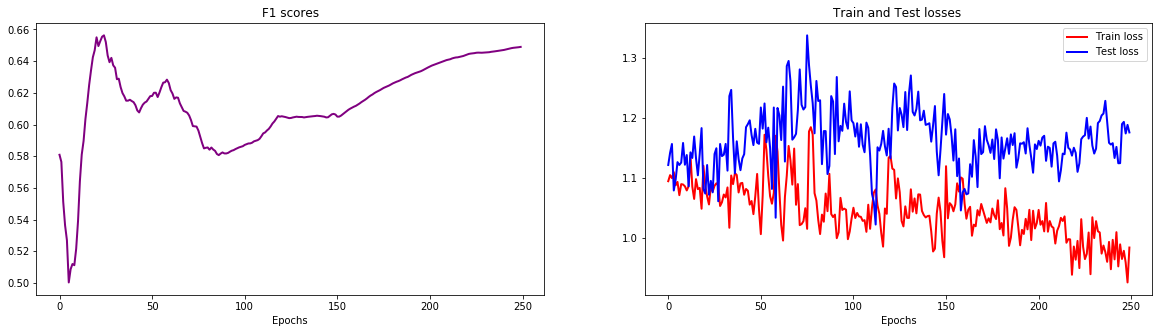

In [16]:
%run trainRNN_plot_utils.py
plot_one_input(F1_scores, trainLosses, testLosses, n_epoch)

In [15]:
# SAVE DATA
# Save the created samples, such tha the NNs can load them easily

# Save data into Python file
import pickle
with open('resultsStatic_HBTRC_ANM.pickle', 'wb') as f:
    pickle.dump( trainLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( testLosses, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( F1_scores, f, pickle.HIGHEST_PROTOCOL )
    pickle.dump( trainAccuracy, f, pickle.HIGHEST_PROTOCOL )
    print( 'Data saved into pickle.' )

Data saved into pickle.
